<a href="https://colab.research.google.com/github/nirmolcho/3d-social-media-icon/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle pandas numpy matplotlib scikit-learn tensorflow keras opencv-python tqdm torch torchvision torchsummary torchmetrics keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = 'molcho'
os.environ['KAGGLE_KEY'] = 'd21a138e95eb9fc14008f826e98a5506'
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset
!unzip deepglobe-road-extraction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/723199_sat.jpg    
  inflating: train/723226_mask.png   
  inflating: train/723226_sat.jpg    
  inflating: train/723436_mask.png   
  inflating: train/723436_sat.jpg    
  inflating: train/723483_mask.png   
  inflating: train/723483_sat.jpg    
  inflating: train/723622_mask.png   
  inflating: train/723622_sat.jpg    
  inflating: train/723722_mask.png   
  inflating: train/723722_sat.jpg    
  inflating: train/723970_mask.png   
  inflating: train/723970_sat.jpg    
  inflating: train/723990_mask.png   
  inflating: train/723990_sat.jpg    
  inflating: train/724095_mask.png   
  inflating: train/724095_sat.jpg    
  inflating: train/724431_mask.png   
  inflating: train/724431_sat.jpg    
  inflating: train/724485_mask.png   
  inflating: train/724485_sat.jpg    
  inflating: train/724705_mask.png   
  inflating: train/724705_sat.jpg    
  inflating: train/724870_mask.png   
  inflating: train/724870_sat.jpg    

In [5]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, JaccardIndex

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [7]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

In [8]:
metadata = pd.read_csv('metadata.csv')
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [9]:
metadata.isnull().sum()

image_id             0
split                0
sat_image_path       0
mask_path         2344
dtype: int64

In [10]:
images = []
masks = []
for i in tqdm(range(6226)):
    image = plt.imread(metadata['sat_image_path'][i])
    mask = plt.imread(metadata['mask_path'][i])
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_CUBIC)
    grayimg = mask[:,:,0]*0.2989+mask[:,:,1]*0.5870+mask[:,:,2]*0.1140
    images.append(image)
    masks.append(grayimg)

  0%|          | 0/6226 [00:00<?, ?it/s]

In [11]:
# get shape
print('Shape of image data: ' + str(images[1].shape))
print('Shape of mask data: ' + str(masks[1].shape))

Shape of image data: (256, 256, 3)
Shape of mask data: (256, 256)


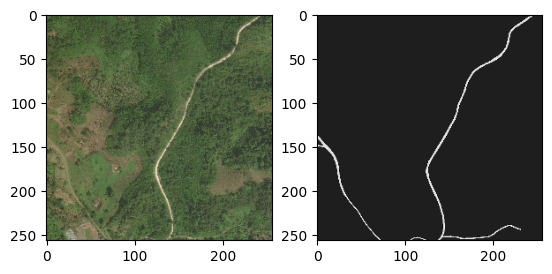

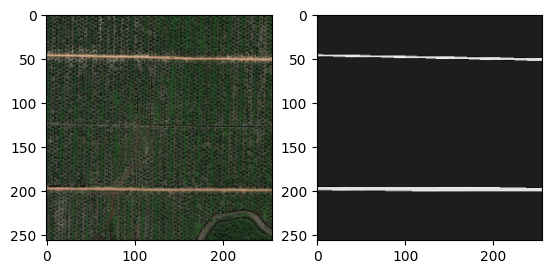

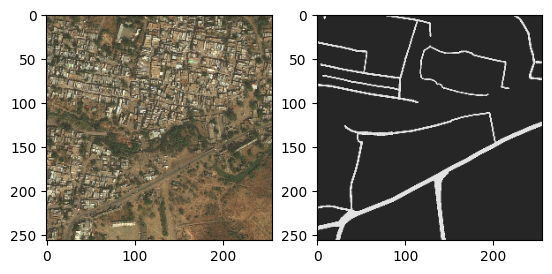

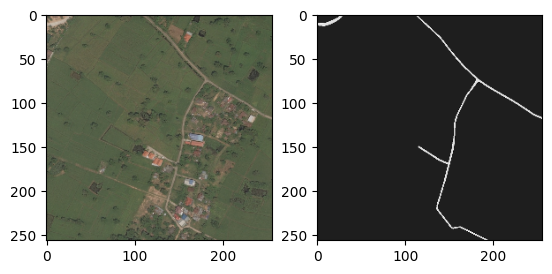

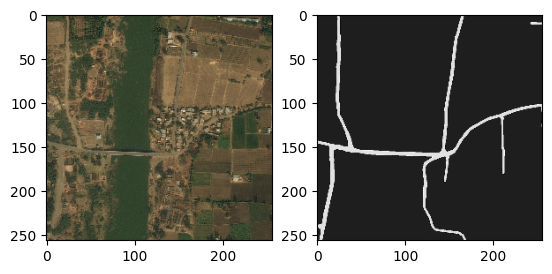

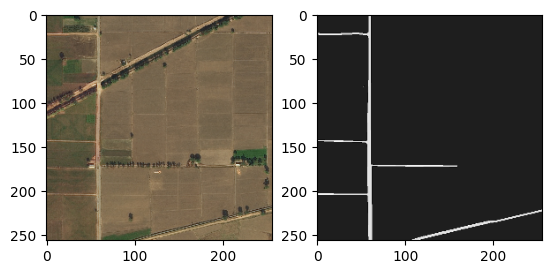

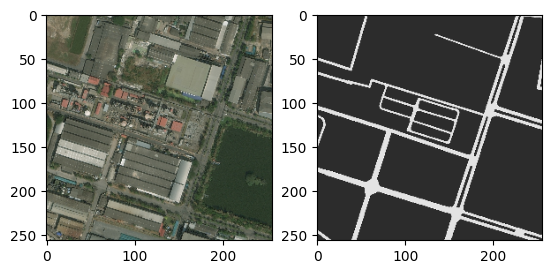

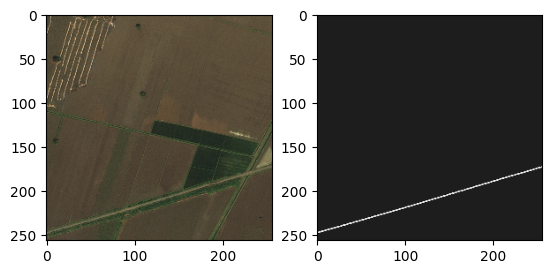

In [12]:
import random
random.seed(48)
for i in range(random.randint(0, 10)):  # Use random.randint() to generate a random integer
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(images[i])
    fig.add_subplot(1,2,2)
    plt.imshow(masks[i],cmap='gray')
    plt.show()

The dataset includes 6226 images and 6226 mask. The images have 3 channels while the masks have only 1.

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images,masks,test_size=0.1,random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

<b>Given that we are predicting a binary mask, the output layer will be designed to accommodate this by having a size of 1.</b>

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def unet(input_shape, output_layer):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    conv4 = tf.image.resize(conv4, tf.shape(up6)[1:3])
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv3 = tf.image.resize(conv3, tf.shape(up7)[1:3])
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv2 = tf.image.resize(conv2, tf.shape(up8)[1:3])
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv1 = tf.image.resize(conv1, tf.shape(up9)[1:3])
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model



In [17]:
# Example usage
unet_model = unet((256, 256, 3), 1)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['batch_normalization[0][0

In [18]:
# Define the callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss'),
    ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')
]

# Replace X_train, y_train, X_test, y_test with actual data
with tf.device("/GPU:0"):
    history = unet_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)


Epoch 1/50
176/176 [==============================] - 47s 121ms/step - loss: 0.4810 - accuracy: 0.8549 - val_loss: 0.2561 - val_accuracy: 0.9436
Epoch 2/50
176/176 [==============================] - 17s 97ms/step - loss: 0.1836 - accuracy: 0.9392 - val_loss: 0.1588 - val_accuracy: 0.9430
Epoch 3/50
176/176 [==============================] - 17s 97ms/step - loss: 0.1115 - accuracy: 0.9395 - val_loss: 0.1266 - val_accuracy: 0.9244
Epoch 4/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0922 - accuracy: 0.9398 - val_loss: 0.0961 - val_accuracy: 0.9398
Epoch 5/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0843 - accuracy: 0.9399 - val_loss: 0.0831 - val_accuracy: 0.9365
Epoch 6/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0787 - accuracy: 0.9399 - val_loss: 0.0779 - val_accuracy: 0.9360
Epoch 7/50
176/176 [==============================] - 17s 95ms/step - loss: 0.0758 - accuracy: 0.9401 - val_loss: 0.0799 - val_accuracy

In [20]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the model from the checkpoint file
unet_model = load_model('model_checkpoint.h5')

# Define the callbacks again
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss'),
    ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')
]

# Calculate remaining epochs
remaining_epochs = 50 - len(history.epoch)

# Continue training from the saved checkpoint
with tf.device("/GPU:0"):
    history = unet_model.fit(X_train, y_train, epochs=remaining_epochs, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)


Epoch 1/23
176/176 [==============================] - 27s 102ms/step - loss: 0.0567 - accuracy: 0.9410 - val_loss: 0.0721 - val_accuracy: 0.9390
Epoch 2/23
176/176 [==============================] - 17s 95ms/step - loss: 0.0561 - accuracy: 0.9409 - val_loss: 0.0725 - val_accuracy: 0.9389
Epoch 3/23
176/176 [==============================] - 17s 96ms/step - loss: 0.0557 - accuracy: 0.9409 - val_loss: 0.0725 - val_accuracy: 0.9389
Epoch 4/23
176/176 [==============================] - 17s 97ms/step - loss: 0.0540 - accuracy: 0.9411 - val_loss: 0.0707 - val_accuracy: 0.9375
Epoch 5/23
176/176 [==============================] - 17s 95ms/step - loss: 0.0532 - accuracy: 0.9411 - val_loss: 0.0791 - val_accuracy: 0.9382
Epoch 6/23
176/176 [==============================] - 17s 95ms/step - loss: 0.0528 - accuracy: 0.9412 - val_loss: 0.0809 - val_accuracy: 0.9402
Epoch 7/23
176/176 [==============================] - 17s 97ms/step - loss: 0.0521 - accuracy: 0.9413 - val_loss: 0.0687 - val_accuracy

In [22]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the model from the checkpoint file
unet_model = load_model('model_checkpoint.h5')

# Define the callbacks again
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss'),
    ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')
]

# Calculate remaining epochs
remaining_epochs = 50 - (27 + 17)  # Adjust based on the actual epochs completed

# Continue training from the saved checkpoint
with tf.device("/GPU:0"):
    history = unet_model.fit(X_train, y_train, epochs=remaining_epochs, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)


Epoch 1/6
176/176 [==============================] - 28s 102ms/step - loss: 0.0514 - accuracy: 0.9413 - val_loss: 0.0697 - val_accuracy: 0.9371
Epoch 2/6
176/176 [==============================] - 17s 95ms/step - loss: 0.0499 - accuracy: 0.9414 - val_loss: 0.0709 - val_accuracy: 0.9387
Epoch 3/6
176/176 [==============================] - 17s 97ms/step - loss: 0.0494 - accuracy: 0.9414 - val_loss: 0.0674 - val_accuracy: 0.9381
Epoch 4/6
176/176 [==============================] - 17s 95ms/step - loss: 0.0505 - accuracy: 0.9414 - val_loss: 0.0709 - val_accuracy: 0.9394
Epoch 5/6
176/176 [==============================] - 17s 95ms/step - loss: 0.0487 - accuracy: 0.9415 - val_loss: 0.0699 - val_accuracy: 0.9374
Epoch 6/6
176/176 [==============================] - 17s 95ms/step - loss: 0.0481 - accuracy: 0.9415 - val_loss: 0.0766 - val_accuracy: 0.9411


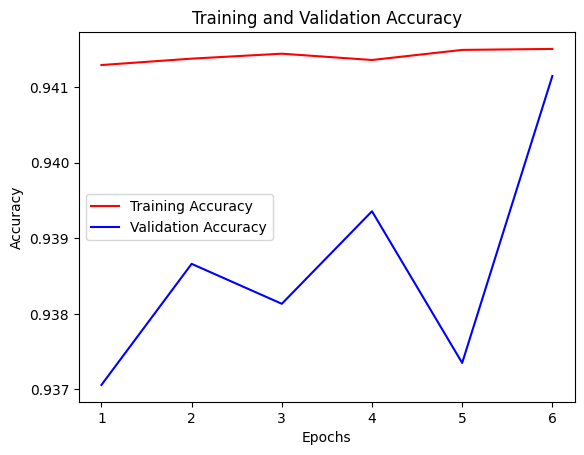

In [24]:
import matplotlib.pyplot as plt

# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Calculate the number of completed epochs
completed_epochs = len(train_accuracy)

# Adjust epochs range based on completed epochs
epochs = range(1, completed_epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:
unet_model.save('models/roads_extraction.h5') # Use 'unet_model' instead of 'model'

In [28]:
eval = unet_model.evaluate(X_train, y_train)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

176/176 [==============================] - 4s 20ms/step - loss: 0.0471 - accuracy: 0.9434
Test accuracy: 0.94


In [33]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('/content/model_checkpoint.h5')

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# display 10 random predictions
random_indices = random.sample(range(0, len(X_test)), 10)
test_sample = X_test[random_indices]

predictions = unet_model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(20, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = y_test[random_indices][i] * 255  # converting the foreground into white color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2)  # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    white_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + white_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(white_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 1s 1s/step


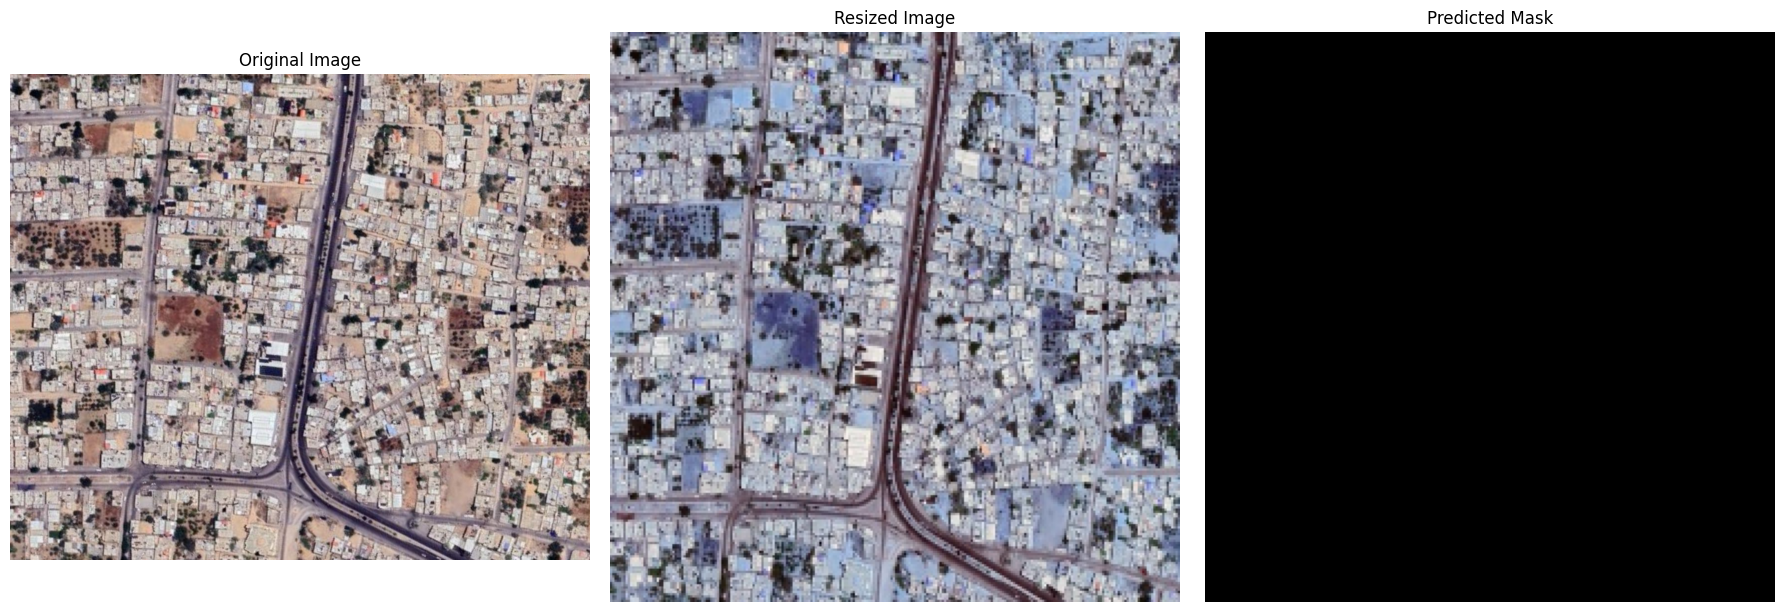

In [32]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to preprocess the new image
def preprocess_image(image_path, target_size):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    # Normalize the image
    normalized_image = resized_image / 255.0
    # Expand dimensions to match the input shape of the model
    preprocessed_image = np.expand_dims(normalized_image, axis=0)
    return image, resized_image, preprocessed_image

# Function to post-process the prediction
def postprocess_prediction(prediction):
    # Threshold the prediction to get a binary mask
    prediction = (prediction > 0.5).astype(np.uint8)
    # Remove the batch dimension
    prediction = np.squeeze(prediction, axis=0)
    return prediction

# Path to the new image
new_image_path = '/content/WhatsApp Image 2024-06-20 at 18.53.16.jpeg'

# Preprocess the new image
target_size = (256, 256)  # The target size should match the input shape of the model
original_image, resized_image, preprocessed_image = preprocess_image(new_image_path, target_size)

# Make a prediction
prediction = unet_model.predict(preprocessed_image)

# Post-process the prediction
binary_mask = postprocess_prediction(prediction)

# Visualize the original image, the resized image, and the prediction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the resized image
axes[1].imshow(resized_image)
axes[1].set_title('Resized Image')
axes[1].axis('off')

# Display the prediction
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Show the plot
plt.tight_layout()
plt.show()
